##  #Capstone Project : McKinsey&Company Prohack
#### --Achieve Singularity

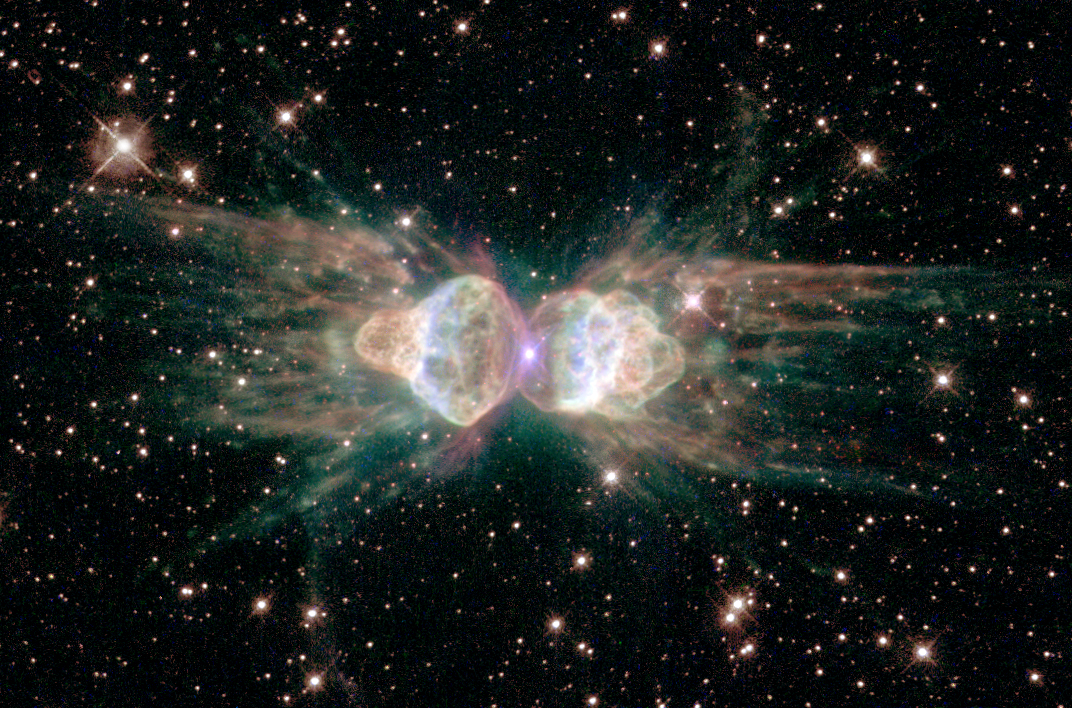

In [789]:
Image(filename='june-30-2019-ant-nebula.jpg') 

In [790]:
#Theme change
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('gruvboxd')

### Importing Libraries

In [796]:
#For data manipulation
import pandas as pd
import numpy as np

#For visualisation
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns 
import missingno as msn

#For preprocessing
from category_encoders import TargetEncoder
from sklearn.preprocessing import RobustScaler

#For modeling
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

#For evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

#Miscellaneous
from warnings import filterwarnings
from scipy.stats import zscore
from IPython.display import Image
import pickle
%matplotlib inline

In [797]:
sns.set(style = 'darkgrid', palette = 'bright')
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (15, 10)
plt.style.use('ggplot')
filterwarnings(action = 'ignore')
%matplotlib inline

### Variable Description

##### ~ galactic_year - the spatial year
##### ~ galaxy - the spatial location
##### ~ existence_expectancy_index - celestial equivalent of life expectancy index 
##### ~ existence_expectancy_at_birth - celestial equivalent of existence expectancy at birth
##### ~ gross_income_per_capita - celestial equivalent of gross income per living alien
##### ~ intergalactic_development_index_(idi) -  celestial equivalent of International development index(IDI)
##### ~ expected_mean_mult - yield of expected and average years of education
##### ~ y - target variable

### Importing Dataset

In [800]:
raw = pd.read_csv('train.csv')
df = raw.copy()

In [801]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3865 entries, 0 to 3864
Data columns (total 80 columns):
 #   Column                                                                                   Non-Null Count  Dtype  
---  ------                                                                                   --------------  -----  
 0   galactic year                                                                            3865 non-null   int64  
 1   galaxy                                                                                   3865 non-null   object 
 2   existence expectancy index                                                               3864 non-null   float64
 3   existence expectancy at birth                                                            3864 non-null   float64
 4   Gross income per capita                                                                  3837 non-null   float64
 5   Income Index                                                  

### Data Cleaning and Preprocessing

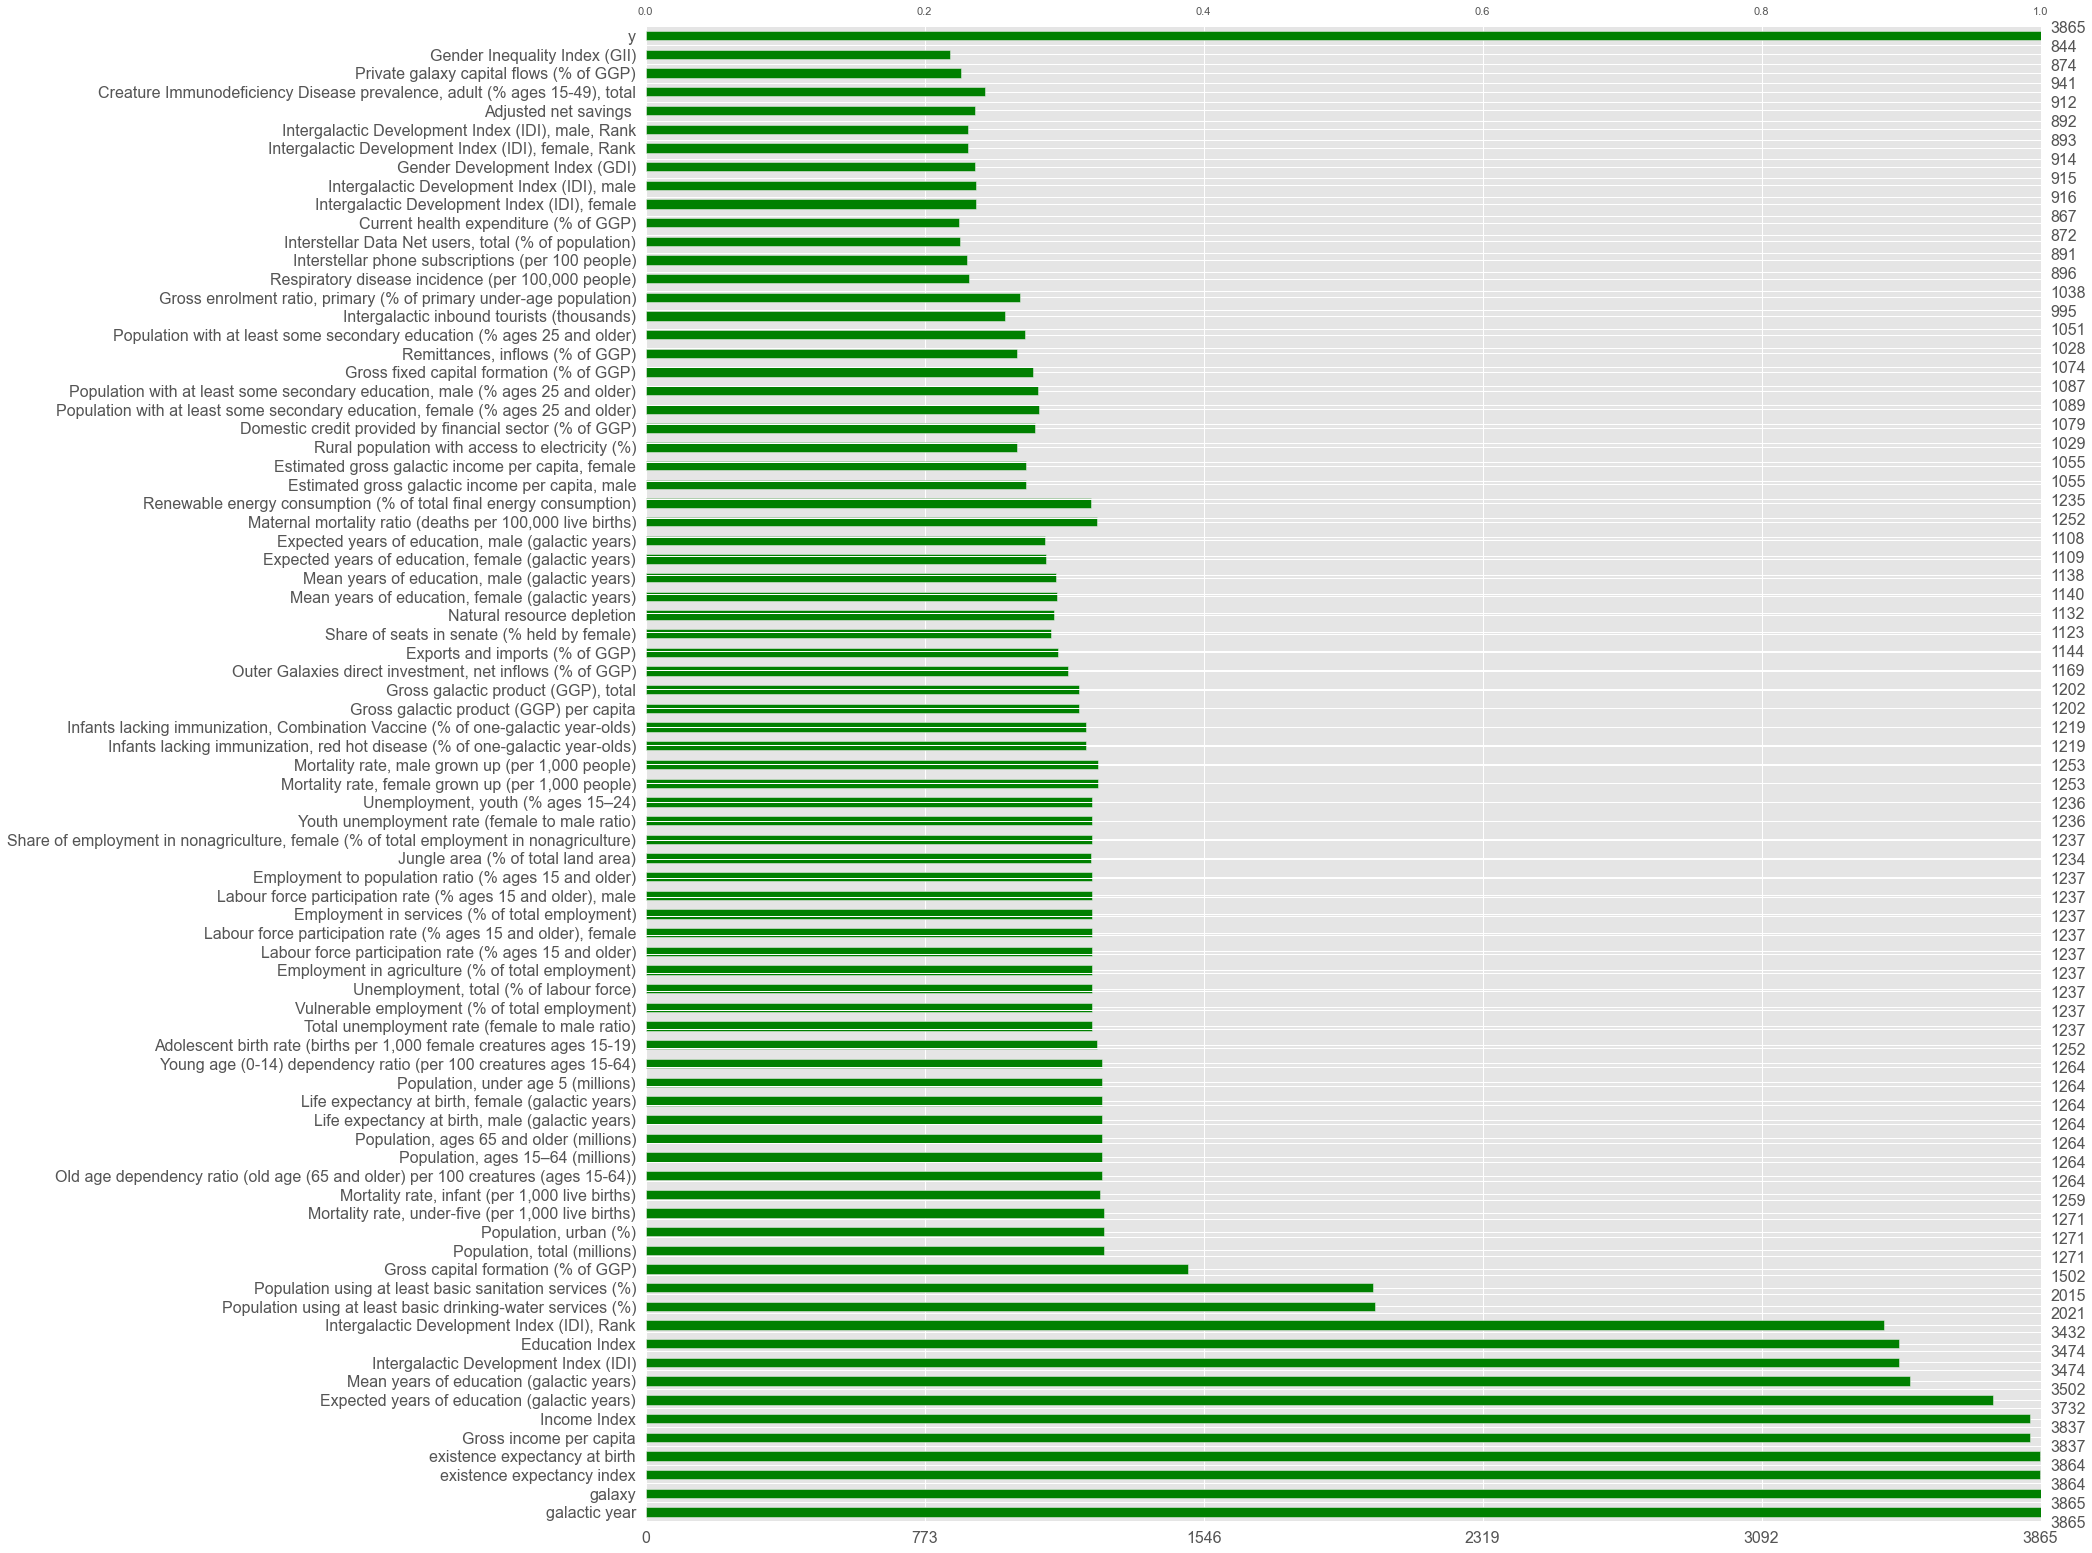

In [802]:
#Visualising the null values
msn.bar(df, color='green')
plt.show()

In [803]:
%%time
#This is the data we're gonna work on
df = df[[f for f in df.columns if f in df.iloc[:,0:11].columns or f=='y']]

Wall time: 120 ms


In [804]:
df.head()

,galactic year,galaxy,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,"Intergalactic Development Index (IDI), Rank",y
0,990025,Large Magellanic Cloud (LMC),0.628657,63.125200,27109.234310,0.646039,8.240543,NaN,NaN,NaN,NaN,0.052590
1,990025,Camelopardalis B,0.818082,81.004994,30166.793958,0.852246,10.671823,4.742470,0.833624,0.467873,152.522198,0.059868
2,990025,Virgo I,0.659443,59.570534,8441.707353,0.499762,8.840316,5.583973,0.469110,0.363837,209.813266,0.050449
3,990025,UGC 8651 (DDO 181),0.555862,52.333293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.049394
4,990025,Tucana Dwarf,0.991196,81.802464,81033.956906,1.131163,13.800672,13.188907,0.910341,0.918353,71.885345,0.154247


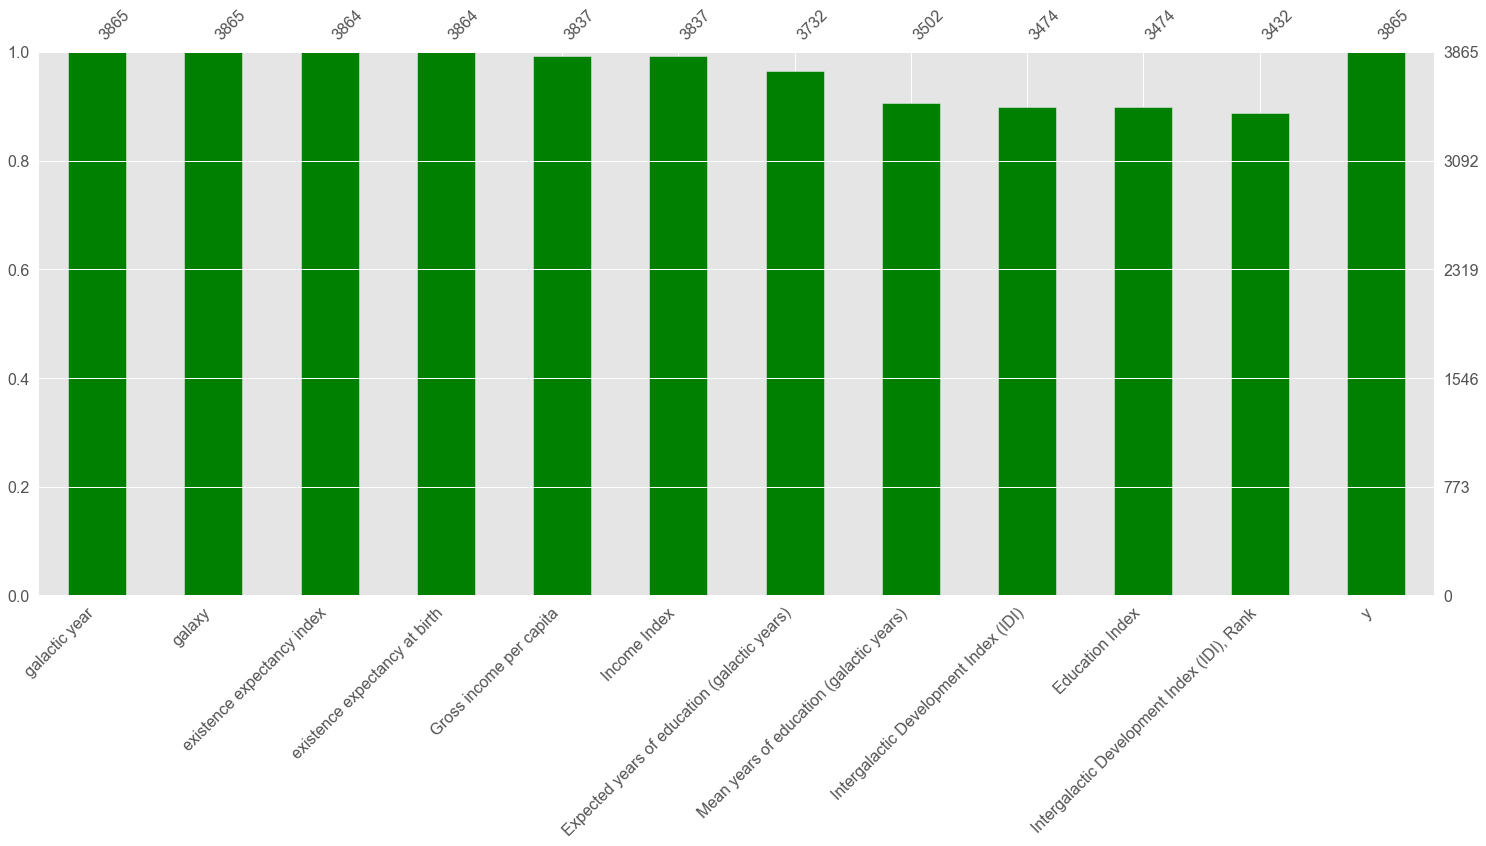

In [590]:
#Null value count after the elimination
msn.bar(df, color='green')
plt.show()

In [805]:
''' Missing values ratio
per column
'''
def column_null_ratio(data):
    ratio = []
    for f in data.columns:
        n_missing = data[f].isna().sum()
        ratio.append(n_missing / data.shape[0])
    return ratio

In [806]:
#Ratio of null values to the entire records
column_null_ratio(df)

[0.0,
 0.0,
 0.000258732212160414,
 0.000258732212160414,
 0.007244501940491591,
 0.007244501940491591,
 0.034411384217335056,
 0.09391979301423027,
 0.10116429495472186,
 0.10116429495472186,
 0.11203104786545925,
 0.0]

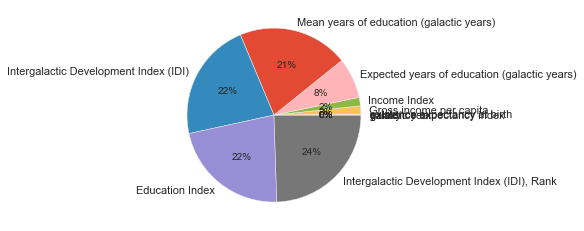

In [347]:
#Visualizing the columnwise proportion of null records 
total_nans = df.isna().sum().sum()
nan_pct_per_col = (df[[f for f in df.columns]].isna().sum()/total_nans)*100 
colors = sns.color_palette('pastel')[0:5]
plt.pie(nan_pct_per_col, labels=df.columns, autopct='%.0f%%')
plt.show()

In [807]:
#Organizing column names 
def column_names_alter(data):
    data.rename(columns=lambda x: x.lower().replace(' ', '_').replace('-', '_').replace(',', ''), inplace=True)
    return print(f'Column names cleaned: {df.columns}')
column_names_alter(df)

Column names cleaned: Index(['galactic_year', 'galaxy', 'existence_expectancy_index',
       'existence_expectancy_at_birth', 'gross_income_per_capita',
       'income_index', 'expected_years_of_education_(galactic_years)',
       'mean_years_of_education_(galactic_years)',
       'intergalactic_development_index_(idi)', 'education_index',
       'intergalactic_development_index_(idi)_rank', 'y'],
      dtype='object')


In [808]:
#Let's make sure the values have no whitespaces at the beginning or at the end
def values_stripper(data):
    for f in data.columns:
        if data[f].dtype == 'O':
            data[f] = data[f].str.strip()
            print(f'The unique values for {f} variable: {data[f].unique()}\n')
values_stripper(df)            

The unique values for galaxy variable: ['Large Magellanic Cloud (LMC)' 'Camelopardalis B' 'Virgo I'
 'UGC 8651 (DDO 181)' 'Tucana Dwarf' 'KKh 060' 'Grus II' 'UGCA 292'
 'Aquarius II' 'Andromeda XI' 'Antlia Dwarf' 'IC 1613 (UGC 668)' 'Leo P'
 'Cassiopeia Dwarf (Cas dSph, Andromeda VII)' 'Draco II' 'Sagittarius II'
 'Carina III' 'UGCA 133 (DDO 44)' 'Lacerta I (Andromeda XXXI)' 'Boötes IV'
 'Maffei 2' 'KUG 1210+301B (KK98 127)' 'Andromeda V'
 'Sagittarius Dwarf Sphr SagDEG' 'UGCA 276 (DDO 113)' 'Ursa Minor Dwarf'
 'UGC 9128 (DDO 187)' 'Andromeda XX' 'Segue 2' 'Fornax Dwarf (E356-G04)'
 'Columba I' 'KK98 77' 'Holmberg II (DDO 50, UGC 4305)'
 'ESO 540-030 (KDG 2)' 'NGC 404' 'UGC 8833' 'Perseus I (Andromeda XXXIII)'
 'Horologium II' 'Andromeda XXVI' 'Grus I' 'Andromeda IX'
 'Andromeda XXII[57]' 'ESO 274-01[70]' 'Leo II Dwarf (Leo B, DDO 93)'
 'Reticulum II' 'Andromeda II' 'Indus II' 'MB 1 (KK98 21)' 'UGCA 105'
 'Crater II' 'Andromeda XVIII[60]' 'KKH 11 (ZOAG G135.74-04.53)'
 'Phoenix Dwarf G

In [809]:
#Checking for duplicates
def duplicate_check_remove(data):
    num_duplicates = data.duplicated().sum()
    if num_duplicates > 0:
        print(f'The number of duplicate rows before: {num_duplicates}')
        data.drop_duplicates(inplace = True)
        print(f'The number of duplicate rows now: {data.duplicated().sum()}')
    else:
        print('There are no duplicate rows in the dataset.')
duplicate_check_remove(df)        

There are no duplicate rows in the dataset.


In [810]:
'''For the categorical columns, 
we'll be using Target Encoding instead of One-hot-encoding 
since the latter would cause massive Multicollinearity which is
one of the assumptions to build a Linear Regression model.
But the main drawback of this sort of encoding is overfitting,
so at the end we'll check whether it overfit more than we expected.
'''
#Checking the number of y instances per galactic year before Target Encoding
#We discover that there's isn't a gigantic gap between the classes and the classes itself aren't too few
display(df.groupby('galactic_year').count()['y'].sort_values().to_frame().T, 
        df.groupby('galaxy').count()['y'].sort_values().to_frame().T)

galactic_year,1015056,1014049,1013042,1012036,1011030,1010025,1009020,1008016,1007012,1006009,1005006,1004004,1003002,1002001,1000000,999000,998001,997002,996004,995006,994009,993012,992016,991020,1001000,990025
y,87,88,89,90,90,90,90,90,90,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,181


galaxy,NGC 5253,"Wolf-Lundmark-Melotte (WLM, DDO 221)",Andromeda XXI[57],Andromeda X,Aquarius Dwarf Galaxy (DDO 210),Sagittarius Dwarf Irregular Galaxy (SagDIG),Pegasus Dwarf Irregular (DDO 216),Perseus I (Andromeda XXXIII),Canes Venatici I Dwarf,"Cassiopeia Dwarf (Cas dSph, Andromeda VII)",Cassiopeia II (Andromeda XXX),Columba I,Fornax Dwarf (E356-G04),Hydra II,Lacerta I (Andromeda XXXI),"Leo I Dwarf (DDO 74, UGC 5470)",Barnard's Galaxy (NGC 6822),Leo T Dwarf,Leo V Dwarf,M110 (NGC 205),Pisces III (Andromeda XIII),NGC 185,"Leo A (Leo III, DDO 69)","Leo II Dwarf (Leo B, DDO 93)",Andromeda Galaxy (M31),Andromeda V,Andromeda XI,Andromeda XVII,Andromeda I,Andromeda XXVI,Andromeda III,Andromeda XXIX,Andromeda IX,ESO 383-087 (ISG 39),Segue 1,ESO 540-032,Sagittarius II,Reticulum III,Pisces I,Phoenix II,HIPASS J1247-77,Sculptor Dwarf (E351-G30),NGC 5102,NGC 4214 (UGC 7278),NGC 4163 (NGC 4167),Hydrus I,NGC 3741,NGC 247,KK98 77,KKH 11 (ZOAG G135.74-04.53),Maffei 1,MB 3,KKh 086,ESO 325-11,Segue 2,Large Magellanic Cloud (LMC),ESO 274-01[70],UGCA 133 (DDO 44),UGC 8833,Carina Dwarf (E206-G220),Carina II,Carina III,UGCA 92,Boötes III,UGC 7577 (DDO 125),Tucana II,Antlia 2,Coma Berenices Dwarf,Crater II,"Small Magellanic Cloud (SMC, NGC 292)",Donatiello I,Draco Dwarf (DDO 208),Dwingeloo 1,Triangulum II,UGCA 105,Cas 1 (KK98 19),KKH 37 (Mai 16),UGCA 15 (DDO 6),Antlia B,KKs 3,KKR 25,UGCA 438 (ESO 407-018),Leo P,KKh 060,IC 5152,IC 4662 (ESO 102-14),IC 3104,ESO 294-010,UGC 4879 (VV124)[61],"Sextans A (92205, DDO 75)",NGC 2403,NGC 300,NGC 3109,NGC 55,UGC 8508 (I Zw 060),Sextans B (UGC 5373),UGC 9128 (DDO 187),Antlia Dwarf,GR 8 (DDO 155),KUG 1210+301B (KK98 127),KKh 98,Andromeda XVIII[60],HIZSS 003,ESO 410-G005,KKR 03 (KK98 230),Hercules Dwarf,IC 342,Camelopardalis B,NGC 1569 (UGC 3056),"Holmberg II (DDO 50, UGC 4305)",Boötes I,Boötes II,Grus II,Grus I,Pictor II,UGC 9240 (DDO 190),UGC 4483,ESO 540-030 (KDG 2),Sextans Dwarf Sph,Draco II,UGC 8651 (DDO 181),Reticulum II,Dwingeloo 2,FM2000 1,Sagittarius Dwarf Sphr SagDEG,ESO 321-014[70],DDO 99 (UGC 6817),Tucana III,NGC 5237,MB 1 (KK98 21),KKH 12,Maffei 2,Ursa Major II Dwarf,Aquarius II,NGC 1560,Tucana IV,UGCA 86,NGC 2366,Ursa Major I Dwarf (UMa I dSph),KK98 35,Indus II,UGCA 292,NGC 404,UGCA 276 (DDO 113),Virgo I,Horologium II,Horologium I,NGC 5206,Ursa Minor Dwarf,Willman 1,Cetus Dwarf,Andromeda XXV,Canes Venatici II Dwarf,Andromeda XXVIII,Boötes IV,Cassiopeia III (Andromeda XXXII),Andromeda XX,Pisces IV (Andromeda XIV),Pegasus Dwarf Sph (And VI),Andromeda VIII,IC 1613 (UGC 668),IC 10 (UGC 192),Andromeda XXIII,Cetus III,Pegasus III,Phoenix Dwarf Galaxy (P 6830),Pisces Dwarf,Pisces II,Andromeda II,Pisces V (Andromeda XVI),Leo IV Dwarf,Eridanus II,Triangulum Galaxy (M33),Andromeda XV,NGC 147 (DDO 3),M32 (NGC 221),Tucana Dwarf,Andromeda XXII[57],Andromeda XXIV,Andromeda XII,Andromeda XIX[60]
y,1,17,17,17,17,17,17,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,20,20,20,21,21,21,21,21,21,21,21,21,21,21,21,21,22,22,22,22,22,22,22,22,22,22,22,22,22,22,23,23,23,23,23,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,26,26,26,26,26


In [811]:
'''One of galaxy classes names NGC 5253 has only 1 value.
Thus, it's average which is required for target encoding
wouldn't give us a fair representation and would
overfit and skew our overall results. That's why we'll have to
either dispose of this record or do some smoothing'''
df = df[df['galaxy']!='NGC 5253']

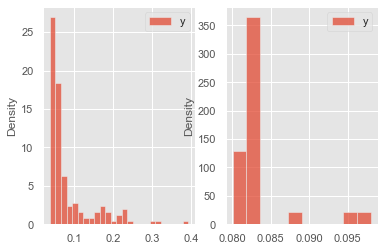

In [812]:
plt.subplot(1, 2, 1)
sns.histplot(data=df.groupby('galaxy').mean()['y'].to_frame(), stat='density')

plt.subplot(1, 2, 2)
sns.histplot(data=df.groupby('galactic_year').mean()['y'].to_frame(), bins=10, stat='density')
plt.show()

In [813]:
#We see that as time progresses, the number of null values decrease per record  
df[df.isna().any(axis=1)].reset_index(drop=True).groupby('galactic_year').count()

,galaxy,existence_expectancy_index,existence_expectancy_at_birth,gross_income_per_capita,income_index,expected_years_of_education_(galactic_years),mean_years_of_education_(galactic_years),intergalactic_development_index_(idi),education_index,intergalactic_development_index_(idi)_rank,y
galactic_year,,,,,,,,,,,
990025,39,39,39,37,37,26,6,3,3,0,39
991020,38,38,38,36,36,25,5,2,2,0,38
992016,42,42,42,40,40,28,9,5,5,1,42
993012,38,38,38,36,36,25,5,2,2,0,38
994009,38,38,38,36,36,25,5,2,2,0,38
995006,34,34,34,32,32,23,4,2,2,0,34
996004,34,34,34,32,32,23,4,2,2,0,34
997002,35,35,35,33,33,23,5,2,2,1,35
998001,34,34,34,32,32,23,4,2,2,0,34


In [814]:
%%time
df['galactic_year'] = df['galactic_year'].astype('O') 
df_numeric = df[[f for f in df.columns if df[f].dtype ==np.number and f!='y']]
df_categoric = df[[f for f in df.columns if df[f].dtype =='O']]
target = df['y']

Wall time: 17 ms


In [815]:
#Our data is split according to different data types
display(df_numeric, df_categoric, target, df_numeric.describe().T)

,existence_expectancy_index,existence_expectancy_at_birth,gross_income_per_capita,income_index,expected_years_of_education_(galactic_years),mean_years_of_education_(galactic_years),intergalactic_development_index_(idi),education_index,intergalactic_development_index_(idi)_rank
0,0.628657,63.125200,27109.234310,0.646039,8.240543,NaN,NaN,NaN,NaN
1,0.818082,81.004994,30166.793958,0.852246,10.671823,4.742470,0.833624,0.467873,152.522198
2,0.659443,59.570534,8441.707353,0.499762,8.840316,5.583973,0.469110,0.363837,209.813266
3,0.555862,52.333293,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.991196,81.802464,81033.956906,1.131163,13.800672,13.188907,0.910341,0.918353,71.885345
...,...,...,...,...,...,...,...,...,...
3860,1.029704,82.832063,34310.471408,0.855094,18.578586,10.557143,0.906573,0.862826,144.896214
3861,0.937869,75.877098,36899.067719,0.929494,16.153857,9.151665,0.865822,0.747577,164.692000
3862,1.036144,93.540275,37002.977875,1.085245,21.066473,16.661344,0.983835,1.100779,63.726437
3863,0.939034,78.274427,28180.459770,0.687655,9.388911,8.908748,0.735694,0.602703,216.805701


,galactic_year,galaxy
0,990025,Large Magellanic Cloud (LMC)
1,990025,Camelopardalis B
2,990025,Virgo I
3,990025,UGC 8651 (DDO 181)
4,990025,Tucana Dwarf
...,...,...
3860,1015056,Columba I
3861,1015056,"Leo II Dwarf (Leo B, DDO 93)"
3862,1015056,Canes Venatici I Dwarf
3863,1015056,KKs 3


0       0.052590
1       0.059868
2       0.050449
3       0.049394
4       0.154247
          ...   
3860    0.042324
3861    0.036725
3862    0.166271
3863    0.024187
3864    0.100069
Name: y, Length: 3864, dtype: float64

,count,mean,std,min,25%,50%,75%,max
existence_expectancy_index,3864.0,0.872479,0.162367,0.227890,0.763027,0.907359,0.992760,1.246908
existence_expectancy_at_birth,3864.0,76.798111,10.461654,34.244062,69.961449,78.995101,84.558971,100.210053
gross_income_per_capita,3836.0,31636.161588,18737.947482,-126.906522,20166.521833,26601.520255,36898.740745,151072.683156
income_index,3836.0,0.825203,0.194056,0.292001,0.677195,0.827303,0.970332,1.361883
expected_years_of_education_(galactic_years),3732.0,14.723296,3.612546,3.799663,12.592467,14.942913,17.123797,26.955944
mean_years_of_education_(galactic_years),3502.0,10.283959,3.319948,1.928166,7.654169,10.385465,12.884752,19.057648
intergalactic_development_index_(idi),3474.0,0.804246,0.176242,0.273684,0.671862,0.824758,0.939043,1.232814
education_index,3474.0,0.745900,0.199795,0.189874,0.597746,0.761255,0.893505,1.269625
intergalactic_development_index_(idi)_rank,3432.0,135.129178,52.449535,9.925906,92.262724,135.914318,175.301993,278.786613


In [816]:
def impute_numeric_via_cat(data, category, method):
    for f in data.columns:
        data[f].fillna(df.groupby(category)[f].transform(method), inplace=True)
    return data.isna().sum()
impute_numeric_via_cat(df_numeric, 'galactic_year', 'median')  

existence_expectancy_index                      0
existence_expectancy_at_birth                   0
gross_income_per_capita                         0
income_index                                    0
expected_years_of_education_(galactic_years)    0
mean_years_of_education_(galactic_years)        0
intergalactic_development_index_(idi)           0
education_index                                 0
intergalactic_development_index_(idi)_rank      0
dtype: int64

In [817]:
def target_encoder_smoother(data, smoothing):
    for f in data.columns:
        t = TargetEncoder(smoothing=smoothing)
        data[f] = t.fit_transform(data[f], target) 
target_encoder_smoother(df_categoric, 3)        

In [818]:
# Coercing the outliers via IQR method
def impute_outliers(value):
    if value > upperlimit:
        value = upperlimit
    elif value < lowerlimit:
        value = lowerlimit
    return value

for feature in df_numeric.columns:
    Q3 = df_numeric[feature].quantile(q = 0.75)
    Q1 = df_numeric[feature].quantile(q = 0.25)
    IQR = Q3 - Q1
    outlier_range = IQR * 2
    upperlimit = Q3 + outlier_range
    lowerlimit = Q1 - outlier_range
    df_numeric[feature] = df_numeric[feature].apply(impute_outliers)

In [819]:
df = pd.concat([df_categoric, df_numeric, target], axis=1)

### EDA (Exploratory Data Analysis) and Feature Engineering

In [820]:
#Let's engineer some new features
df['expected_mean_mult'] = df['expected_years_of_education_(galactic_years)']*df['mean_years_of_education_(galactic_years)']

In [821]:
#Let's engineer some new features
df.drop(['expected_years_of_education_(galactic_years)', 'mean_years_of_education_(galactic_years)'],
       axis=1, inplace=True)

In [822]:
df.drop('y', axis=1, inplace=True)

In [823]:
df = pd.concat([df, target], axis=1)

In [824]:
df.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
galactic_year,0.082132,0.082132,0.082132,0.082132,0.082132,0.082132,0.082132,0.082132,0.082132,0.082132,0.082132,0.082132,0.082132,0.082132,0.082132,0.082132,0.082132,0.082132,0.082132,0.082132
galaxy,0.047845,0.057968,0.042356,0.041066,0.208889,0.044013,0.047991,0.055904,0.046019,0.045008,0.057404,0.041116,0.210406,0.176794,0.044140,0.087524,0.079591,0.046466,0.069493,0.055097
existence_expectancy_index,0.628657,0.818082,0.659443,0.555862,0.991196,0.824692,0.657457,0.951043,0.657402,0.657180,0.828028,0.655813,1.068957,0.951549,0.561894,0.900157,0.989456,0.562213,0.831218,0.833808
existence_expectancy_at_birth,63.125200,81.004994,59.570534,52.333293,81.802464,63.887135,68.555326,75.693397,61.337084,62.554929,71.256422,58.704321,90.854092,85.030094,58.912252,87.736478,75.800059,59.069890,75.583884,70.506143
gross_income_per_capita,27109.234310,30166.793958,8441.707353,25130.444391,69936.879355,28409.062695,25648.328827,20935.541513,18231.029378,16196.125655,21431.826516,23271.835536,48579.590188,39647.220197,18747.428699,29302.252053,24891.436792,17551.455514,27631.426302,17635.842078
income_index,0.646039,0.852246,0.499762,0.818296,1.131163,0.671697,0.745674,0.947961,0.826377,0.679096,0.856276,0.612368,1.082535,1.000001,0.604681,0.900095,0.752552,0.638409,0.915378,0.827792
intergalactic_development_index_(idi),0.785905,0.833624,0.469110,0.785905,0.910341,0.815264,0.662192,0.785905,0.725536,0.561520,0.754593,0.531766,1.053766,0.867767,0.492966,0.896661,0.751911,0.552880,0.872507,0.615988
education_index,0.677720,0.467873,0.363837,0.677720,0.918353,0.796807,0.743891,0.677720,0.647240,0.482450,0.748314,0.285880,0.964813,0.774059,0.396193,0.813344,0.802376,0.488571,0.793564,0.461565
intergalactic_development_index_(idi)_rank,124.822847,152.522198,209.813266,124.822847,71.885345,121.839696,149.567075,124.822847,168.487029,154.098787,159.343087,177.329281,75.269476,95.377798,124.822847,81.698352,98.696254,171.343274,123.529858,132.179592
expected_mean_mult,72.820972,50.610797,49.364081,123.413484,182.015772,140.323605,154.681726,131.341999,105.330410,84.470633,168.148409,31.117768,234.356997,227.256985,19.481401,190.532111,196.457058,60.138503,194.992418,105.048020


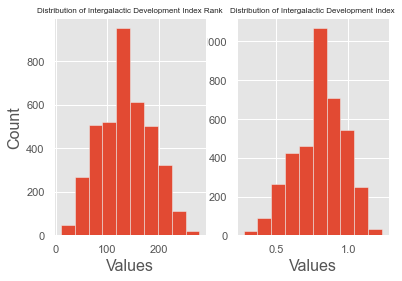

In [825]:
'''Based on the numbers above, we suspect that the variables
intergalactic_development_index_(idi) and intergalactic_development_index_(idi)_rank
are correlated which is not ideal for a Linear Regression model'''
#Let's figure out which correlation test to employ depending on the normality of the following columns
plt.subplot(1, 2, 2)
plt.hist(df['intergalactic_development_index_(idi)'])
plt.title(label = 'Distribution of Intergalactic Development Index', fontsize = 8)
plt.xlabel(xlabel = 'Values', fontsize = 16)
plt.ylabel(ylabel = 'Count', fontsize = 16)

plt.subplot(1, 2, 1)
plt.hist(df['intergalactic_development_index_(idi)_rank'])
plt.title(label = 'Distribution of Intergalactic Development Index Rank', fontsize = 8)
plt.xlabel(xlabel = 'Values', fontsize = 16)
plt.ylabel(ylabel = 'Count', fontsize = 16)
plt.show()
#Very little skewness is observed, so we use pearson correlation for these two continuous variables

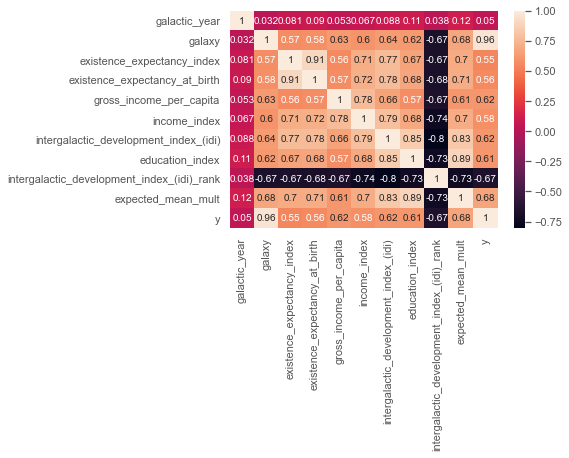

In [741]:
#Significant linear correlation is discovered
sns.heatmap(df.corr(method='pearson'), annot=True)
plt.show()

In [826]:
#To counter this, the IDI rank column is dropped
df.drop('intergalactic_development_index_(idi)_rank', axis=1, inplace=True)  

In [827]:
#2 index columns(income and education) derive the IDI column, so we have no need of them
df.drop(['income_index', 'education_index'], axis=1, inplace=True)

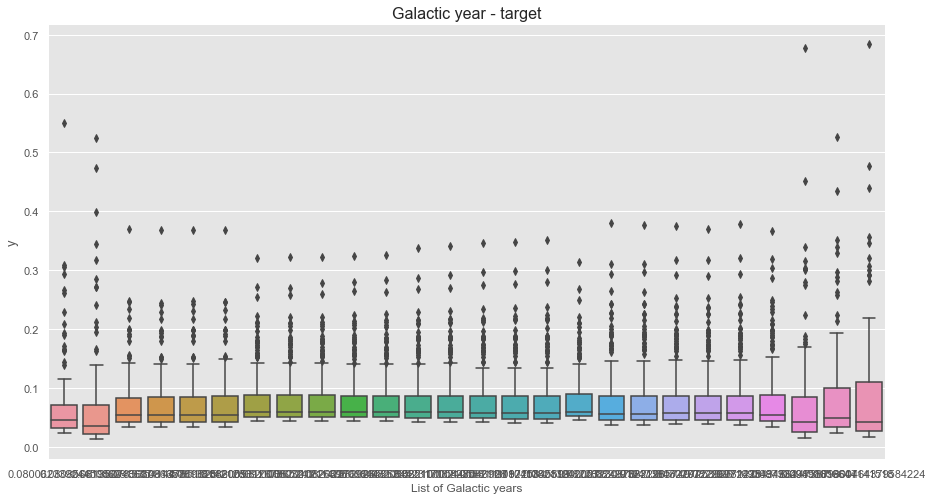

In [828]:
#Let's visualize the distibution of out target variable per galactic year
plt.figure(figsize=(15,8))
#sns.set_style("whitegrid")
#sns.set_palette("Reds", 4)
sns.boxplot(x="galactic_year",y="y",data=df)
#sns.stripplot(x="galactic_year", y="y", data=df, jitter=0.4, color="0.3")
plt.title("Galactic year - target", fontsize=16)
plt.xlabel("List of Galactic years")
plt.ylabel("y", fontsize=13)
plt.show()

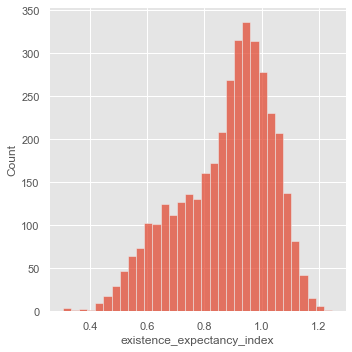

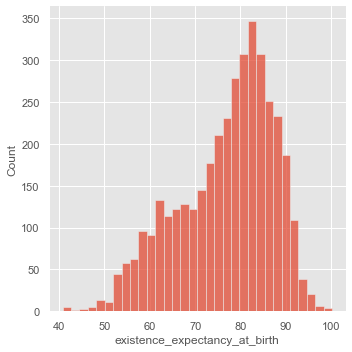

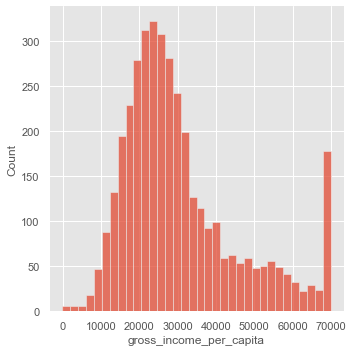

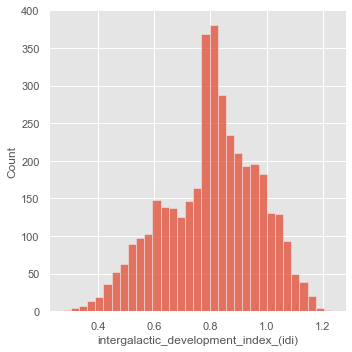

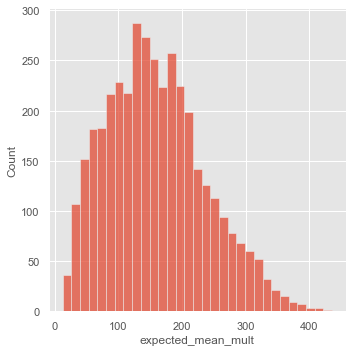

In [829]:
#Let's view the histogram distributions of the remaining continuous features
cols = df.columns[2:-1]
for f in cols:
    sns.displot(df[f])
    plt.show()

### Modeling
#### 1. Linear Regression
#### 2. XGB Regressor
#### 3. GradientBoosting Regressor

In [830]:
scaler = RobustScaler()
df.iloc[:,:-1] = scaler.fit_transform(df.iloc[:,:-1])
df = pd.DataFrame(df)

In [831]:
df.tail()

,galactic_year,galaxy,existence_expectancy_index,existence_expectancy_at_birth,gross_income_per_capita,intergalactic_development_index_(idi),expected_mean_mult,y
3860,-4.371891,0.162328,0.532552,0.262850,0.469524,0.410086,0.407893,0.042324
3861,-4.371891,-0.054632,0.132804,-0.213598,0.625817,0.232257,-0.038673,0.036725
3862,-4.371891,1.191129,0.560583,0.996414,0.632091,0.747245,1.839607,0.166271
3863,-4.371891,-0.265748,0.137877,-0.049370,0.099407,-0.335602,-0.632139,0.024187
3864,-4.371891,1.566321,0.543609,0.866329,2.620567,1.566774,1.427343,0.100069


In [832]:
X = df.drop('y', axis=1) 
y = df['y']

In [833]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=29)

In [834]:
model = LinearRegression()
lin = model.fit(X_train, y_train)  

In [835]:
pred = model.predict(X_test.values)

In [836]:
xgb_model = xgb.XGBRegressor()

In [837]:
xgb_model.fit(X_train, y_train)
preds = xgb_model.predict(X_test)

In [838]:
grad = GradientBoostingRegressor()
grad.fit(X_train,y_train)
pre = grad.predict(X_test)

### Evaluation

In [839]:
#Evaluation results Linear Regression model
print(f'R^2: {r2_score(y_test,pred)}')
print(f'Root Mean Squared Error: {(mean_squared_error(y_test, pred, squared=False))}')
print(f'Mean Squared Error: {mean_squared_error(y_test, pred)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test,pred)}')

R^2: 0.9575045377041332
Root Mean Squared Error: 0.012060026580858996
Mean Squared Error: 0.00014544424113102552
Mean Absolute Error: 0.006901604541598061


In [840]:
#Check overfitting for Linear Regression
display(model.score(X_train,y_train),
model.score(X_test,y_test))

0.9267873771006276

0.9575045377041332

In [841]:
#Evaluation results XGBoost Regressor model
print(f'R^2: {r2_score(y_test,preds)}')
print(f'Root Mean Squared Error: {(mean_squared_error(y_test, preds, squared=False))}')
print(f'Mean Squared Error: {mean_squared_error(y_test, preds)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test,preds)}')

R^2: 0.9830611171112087
Root Mean Squared Error: 0.007614113890804526
Mean Squared Error: 5.797473034214243e-05
Mean Absolute Error: 0.0026197148979573374


In [842]:
#Check overfitting for XGBoost
display(xgb_model.score(X_train, y_train),
xgb_model.score(X_test, y_test))

0.999803614594801

0.9830611171112087

In [843]:
#Evaluation results GradientBoosting model
print(f'R^2: {r2_score(y_test,pre)}')
print(f'Root Mean Squared Error: {(mean_squared_error(y_test, pre, squared=False))}')
print(f'Mean Squared Error: {mean_squared_error(y_test, pre)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test,pre)}')

R^2: 0.9802225777518404
Root Mean Squared Error: 0.008227385156756176
Mean Squared Error: 6.768986651761184e-05
Mean Absolute Error: 0.0036367531483102685


In [844]:
#Check overfitting for GradientBoosting model
display(grad.score(X_train,y_train),
grad.score(X_test,y_test))

0.9929175413070543

0.9802225777518404